## To analyse synthesis and uncertainty

### Set parameters

In [5]:
RUN_ID = 22 # set this to prevent overlapped saving of model and data
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/cont_syn"
QR_REGRESSION = True

In [6]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [7]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir_root = os.path.join("..", "figs")
fig_save_dir = os.path.join(fig_save_dir_root, "runs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [8]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']

logger.info("PARAMETERS\n-----------------")
logger.info(f"RUN_ID: {RUN_ID}")
logger.info(f"QR_REGRESSION: {QR_REGRESSION}")
logger.info(f"ROOT_DIR: {ROOT_DIR}")
print("")

[INFO] PARAMETERS
-----------------
[INFO] RUN_ID: 22
[INFO] QR_REGRESSION: True
[INFO] ROOT_DIR: /scratch1/sachinsa/cont_syn



In [9]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
print("Max epochs:", max_epochs)

Max epochs: 950


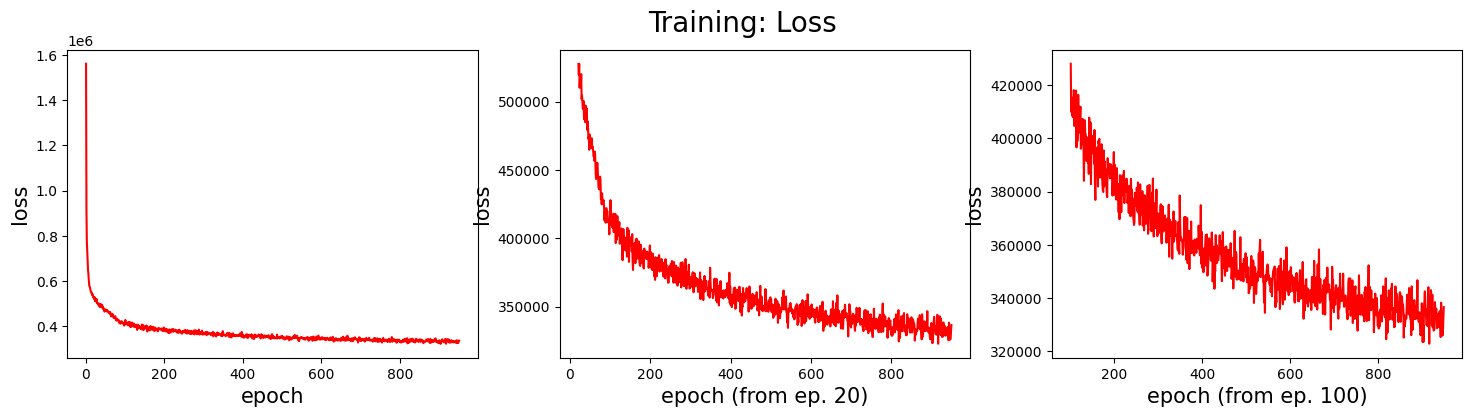

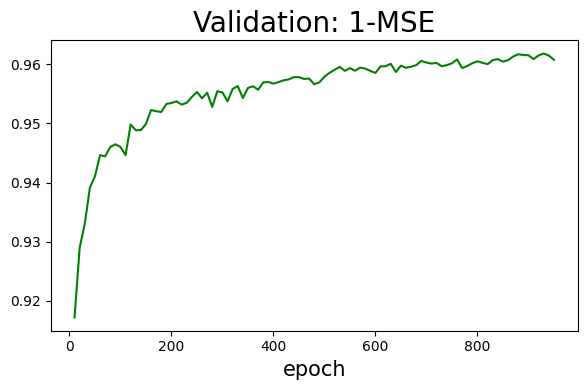

In [10]:
MULTI_TRAINING_FIGURE = True

if not MULTI_TRAINING_FIGURE:
    plt.figure("train", (6, 4))
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.ylabel("loss - log")
    plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.title("Training: Gaussian Log Likelihood Loss", fontsize=25)
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()
else:
    plt.figure("train", (18, 4))
    plt.subplot(1, 3, 1)
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    # plt.ylabel("loss - log", fontsize=15)
    # plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.suptitle("Training: Loss", fontsize=20)

    k = 2
    for zoom in [20, 100]:
        if len(x) > zoom:
            plt.subplot(1, 3, k)
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.ylabel("loss", fontsize=15)
            plt.xlabel(f"epoch (from ep. {zoom})", fontsize=15)
            
            plt.plot(x[zoom:], y[zoom:], color="red")
        k += 1
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()

plt.figure("val", (6, 4))
plt.title("Validation: 1-MSE", fontsize=20)
x_val = [val_interval * (i + 1) for i in range(len(metric_values))]
y_val = metric_values
plt.xlabel("epoch", fontsize=15)
plt.tight_layout()
plt.plot(x_val, y_val, color="green")
plt.savefig(os.path.join(fig_save_dir, "val_plot.png"), facecolor='white')
# plt.ylim([0, 1])
plt.show()

## Inference on the model

In [11]:
import torch

from utils.model import create_UNet3D, inference
from utils.transforms import contr_syn_transform_2 as data_transform
from utils.dataset import BraTSDataset

In [12]:
device = torch.device("cuda:0")
out_channels = 12 if QR_REGRESSION else 8
model = create_UNet3D(out_channels, device)

In [13]:
val_dataset = BraTSDataset(
    version='2017',
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [14]:
val_dataset.ids

array([429, 371,  22,  60, 128,  90, 143, 317, 238,  76,  97, 464,  73,
        71, 381, 225, 308, 107, 397, 412, 141, 219,   5, 242, 151, 213,
        59,  21, 428, 346, 423, 194,  12, 284, 417, 109, 173,  61,  11,
       364, 187, 312, 450, 255, 347,  75, 414, 199,  99, 172, 349, 211,
       264, 102, 329,  63, 290, 331, 272, 200, 436, 305, 293, 378, 191,
       175,  85, 383, 289,  52, 278, 341, 328, 454, 335, 263, 248,  33,
       357, 196, 229,  68, 298, 115, 448,  29, 223, 373, 214,  41,  91,
       167,  88, 406, 189, 388, 363])

In [15]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]
# input_mask = [True, False, True, False]
input_mask = [True, False, False, True]
input_mask = np.array(input_mask)

# interesting ids with tummor: 328, 448

id_ = 429
with torch.no_grad():
    # this_input = val_dataset.get_random()
    this_input = val_dataset.get_with_id(id_)
    input_image = this_input["image"].unsqueeze(0).to(device)
    input_label = this_input["label"]
    input_image_copy = input_image.clone()
    input_image_copy[:, input_mask, ...] = 0
    this_output = inference(input_image_copy, model)

In [16]:
from utils.plot import BrainPlot

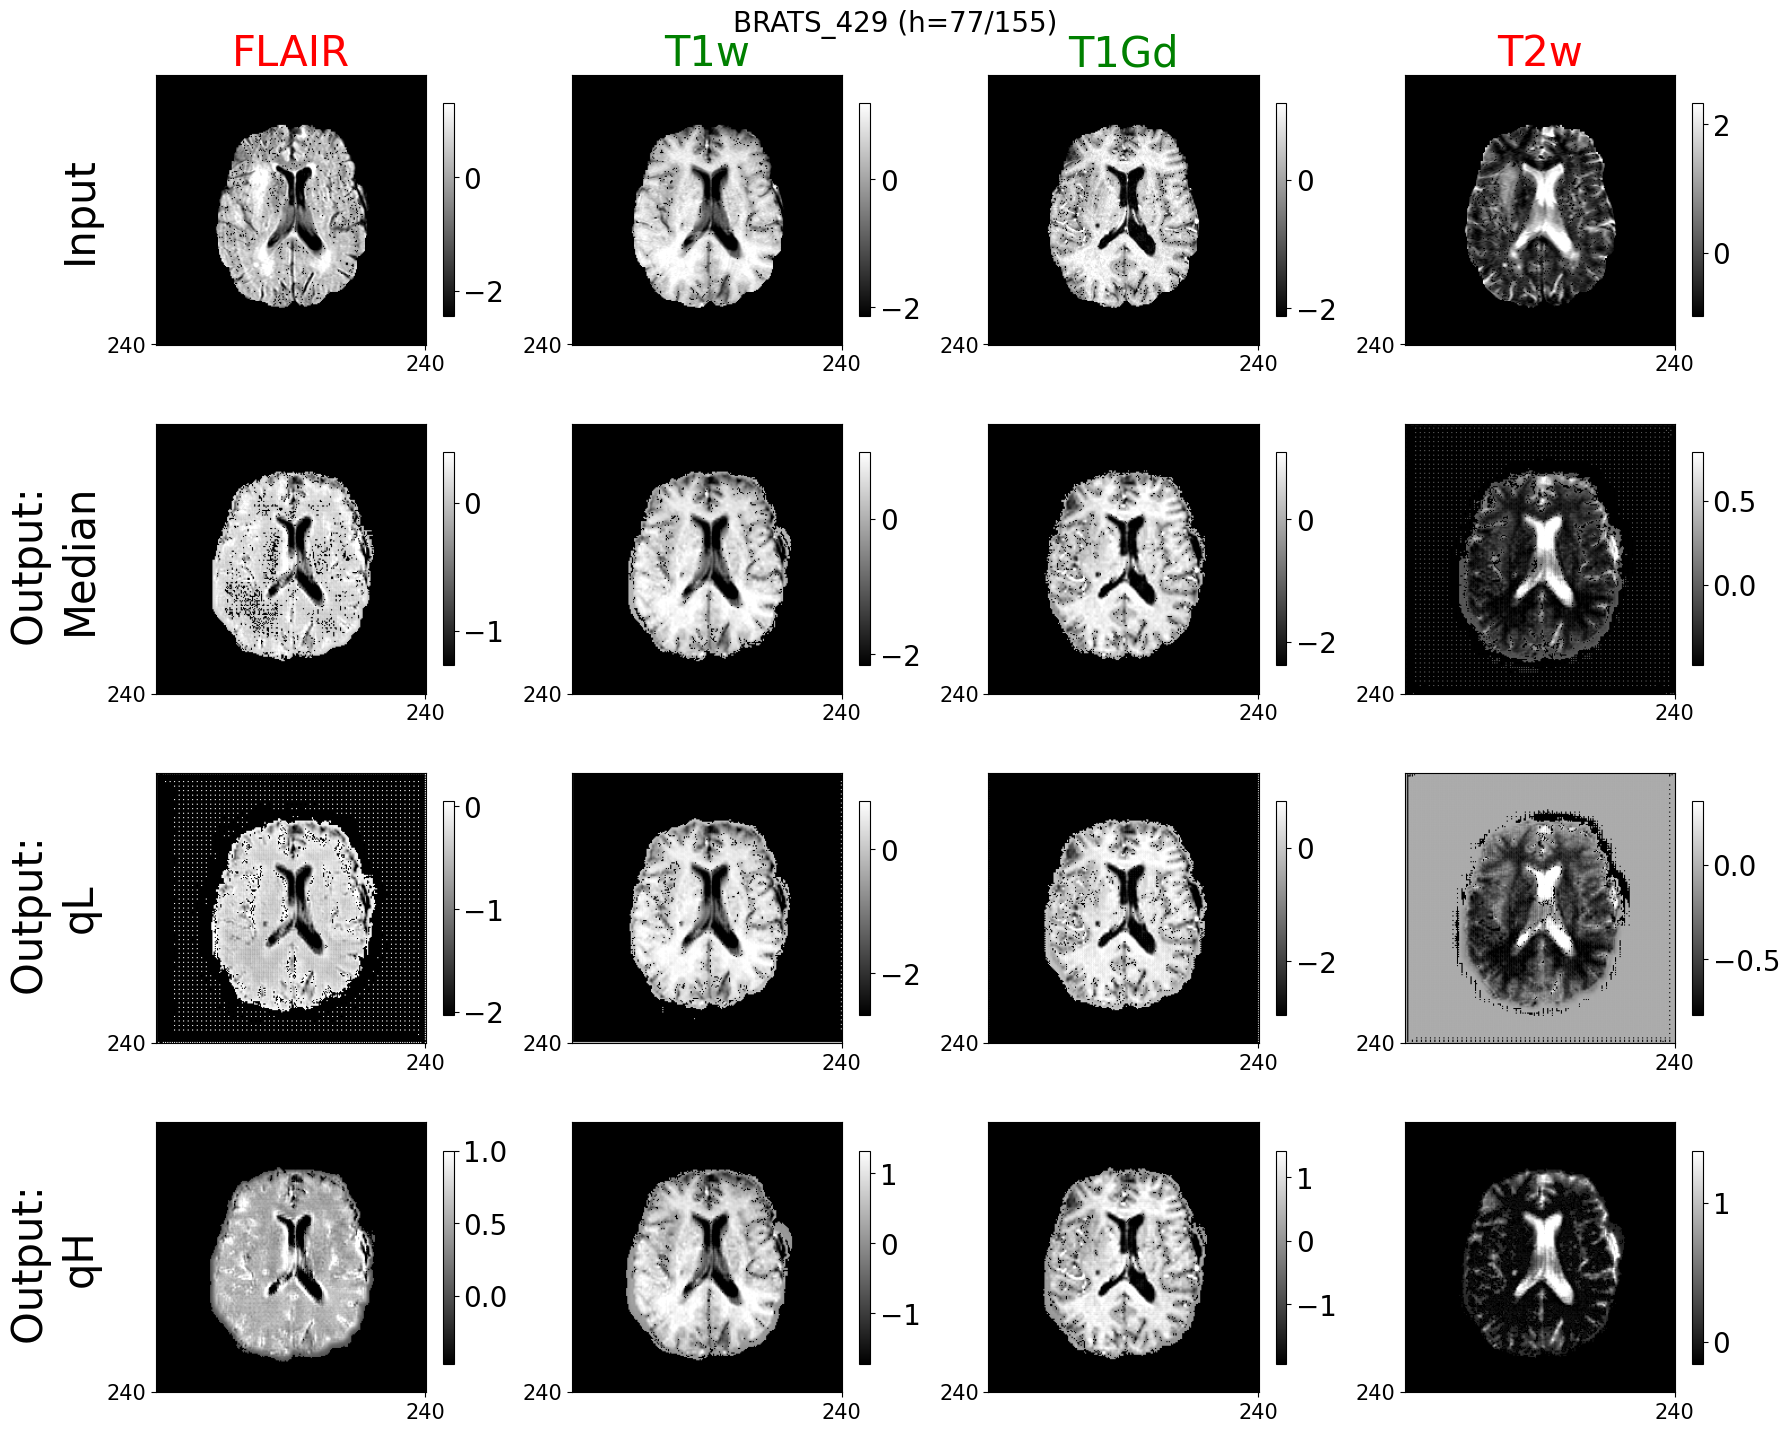

In [17]:
plt.figure("image", (18, 18))
b_plot = BrainPlot(input_image, this_output, input_mask, h_index=77, id=id_)
for i in range(4):
    b_plot.plot("input")
for i in range(4):
    b_plot.plot("q0")
for i in range(4):
    b_plot.plot("q1")
for i in range(4):
    b_plot.plot("q2")
plt.savefig(os.path.join(fig_save_dir_root, "results", f"brats_{id_}.png"), facecolor='white')

### Evaluation metrics

In [25]:
from monai.data import DataLoader
from monai.metrics import MSEMetric
import torch.nn.functional as torch_F
from torchmetrics.functional import structural_similarity_index_measure

mse_metric = MSEMetric(reduction="mean")

# def compute_psnr(predicted, ground, mse):
#     peak_signal_value = torch.max(ground) - torch.min(ground)
#     psnr = 20 * torch.log10(peak_signal_value / torch.sqrt(mse))
#     return psnr


def compute_ssim(predicted, ground):
    return structural_similarity_index_measure(predicted, ground, data_range=ground.max() - ground.min()).item()

def filter_with_mask(data, mask):
    return data[:, mask, ...]


In [19]:
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)
print(len(val_dataset.get_ids()))

97


In [20]:
is_masked = None

if is_masked == True:
    print("True")
elif is_masked == False:
    print("False")
else:
    print("None")

None


In [27]:
is_masked = None

def evaluate_metric(is_masked):
    ssim_list = []
    psnr_list = []

    model.eval()
    i = 0
    with torch.no_grad():
        for this_input in val_loader:
            i+=1
            if i > 2: break
            this_groundtruth = this_input["image"].to(device)
            input_image_copy = this_groundtruth.clone()
            input_image_copy[:, input_mask, ...] = 0
            this_output = inference(input_image_copy, model)
            this_predicted = this_output[:,:4,...].to(device)

            if is_masked == True:
                this_groundtruth = filter_with_mask(this_groundtruth, input_mask)
                this_predicted = filter_with_mask(this_predicted, input_mask)
            elif is_masked == False:
                this_groundtruth = filter_with_mask(this_groundtruth, ~input_mask)
                this_predicted = filter_with_mask(this_predicted, ~input_mask)

            ssim_list.append(
                compute_ssim(this_predicted, this_groundtruth)
            )

            mse_loss_val = torch_F.mse_loss(this_predicted, this_groundtruth)
            peak_signal_value = torch.max(this_groundtruth) - torch.min(this_groundtruth)
            psnr_score = 20 * torch.log10(peak_signal_value / torch.sqrt(mse_loss_val))
            psnr_list.append(psnr_score.item())

    return np.mean(psnr_list), np.mean(ssim_list)

psnr_score, ssim_score = evaluate_metric(is_masked=None)
print("Overall score:")
print(f"PSNR: {psnr_score:.1f}")
print(f"SSIM: {ssim_score:.3f}")

psnr_score, ssim_score = evaluate_metric(is_masked=True)
print("Masked score:")
print(f"PSNR: {psnr_score:.1f}")
print(f"SSIM: {ssim_score:.3f}")

psnr_score, ssim_score = evaluate_metric(is_masked=False)
print("Unmasked score:")
print(f"PSNR: {psnr_score:.1f}")
print(f"SSIM: {ssim_score:.3f}")

/home1/sachinsa/.conda/envs/big_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Overall score:
PSNR: 36.1
SSIM: 0.923
Masked score:
PSNR: 31.0
SSIM: 0.851
Unmasked score:
PSNR: 42.8
SSIM: 0.978


In [23]:
print(np.mean(ssim_list))
print(np.mean(psnr_list))

0.9232646822929382
[metatensor(36.4793, device='cuda:0'), metatensor(35.7463, device='cuda:0')]


In [ ]:
ssim_score_list = {
    'overall': [],
    'mask': [],
    'no_mask': []
}

mse_score_obj_list = {
    'overall': MSEMetric(reduction="mean"),
    'mask': MSEMetric(reduction="mean"),
    'no_mask': MSEMetric(reduction="mean")
}

mse_score_dict = {
    'overall': None,
    'mask': None,
    'no_mask': None
}

psnr_score_list = {
    'overall': None,
    'mask': None,
    'no_mask': None
}

peak_signal_value = -1.

model.eval()
i = 0
with torch.no_grad():
    for this_input in val_loader:
        i+=1
        if i > 2: break
        this_groundtruth = this_input["image"].to(device)
        input_image_copy = this_groundtruth.clone()
        input_image_copy[:, input_mask, ...] = 0
        this_output = inference(input_image_copy, model)
        this_predicted = this_output[:,:4,...].to(device)

        this_groundtruth_masked = filter_with_mask(this_groundtruth, input_mask)
        this_groundtruth_unmasked = filter_with_mask(this_groundtruth, ~input_mask)
        this_predicted_masked = filter_with_mask(this_predicted, input_mask)
        this_predicted_unmasked = filter_with_mask(this_predicted, ~input_mask)

        ssim_score_list['overall'].append(
            compute_ssim(this_predicted, this_groundtruth)
        )
        ssim_score_list['mask'].append(
            compute_ssim(this_predicted_masked, this_groundtruth_masked)
        )
        ssim_score_list['no_mask'].append(
            compute_ssim(this_predicted_unmasked, this_groundtruth_unmasked)
        )

        mse_score_obj_list['overall'](y_pred=this_predicted, y=this_groundtruth)
        mse_score_obj_list['mask'](y_pred=this_predicted_masked, y=this_groundtruth_masked)
        mse_score_obj_list['no_mask'](y_pred=this_predicted_unmasked, y=this_groundtruth_unmasked)

        peak_signal_value = max(torch.max(this_groundtruth).item() - torch.min(this_groundtruth).item(), peak_signal_value)

    mse_score_dict['overall'] = mse_score_obj_list['overall'].aggregate().item()
    mse_score_obj_list['overall'].reset()
    mse_score_dict['mask'] = mse_score_obj_list['mask'].aggregate().item()
    mse_score_obj_list['mask'].reset()
    mse_score_dict['no_mask'] = mse_score_obj_list['no_mask'].aggregate().item()
    mse_score_obj_list['no_mask'].reset()


/home1/sachinsa/.conda/envs/big_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


In [32]:
peak_signal_value

17.947516918182373

In [28]:
print(mse_score_dict)

{'overall': 0.07536574453115463, 'mask': 0.1351267695426941, 'no_mask': 0.015604710206389427}


In [17]:
ssim_score_list

{'overall': [0.9237222075462341, 0.9228070974349976],
 'mask': [0.8649352788925171, 0.8378321528434753],
 'no_mask': [0.9768701791763306, 0.9794382452964783]}

In [18]:
id_ = 429
with torch.no_grad():
    # this_input = val_dataset.get_random()
    this_input = val_dataset.get_with_id(id_)
    input_image = this_input["image"].unsqueeze(0).to(device)
    input_label = this_input["label"]
    input_image_copy = input_image.clone()
    input_image_copy[:, input_mask, ...] = 0
    this_output = inference(input_image_copy, model)

In [19]:
print(input_image.shape)

torch.Size([1, 4, 240, 240, 155])


In [20]:
print(this_output.shape)

torch.Size([1, 12, 240, 240, 155])


In [21]:
this_mask = torch.tensor(input_mask, device=device)[None,:,None,None,None]
print(this_mask.shape)

torch.Size([1, 4, 1, 1, 1])


In [22]:
model.eval()
with torch.no_grad():
    # this_mask = torch.from_numpy(all_mask_df.loc[this_ids.tolist(), :].values).to(device)[:,:,None,None,None]
    this_predicted = this_output[:,:4,...].to(device)
    # this_predicted = this_predicted*this_mask
    this_groundtruth = input_image
    # this_groundtruth = this_groundtruth*this_mask
    mse_metric(y_pred=this_predicted, y=this_groundtruth)

    mse = mse_metric.aggregate()
    mse_metric.reset()

    peak_signal_value = torch.max(this_groundtruth) - torch.min(this_groundtruth)
    psnr = 20 * torch.log10(peak_signal_value / torch.sqrt(mse))

print(f"mse error: {mse.item()}")
print(f"psnr: {psnr.item()}")

mse error: 0.07061316817998886
psnr: 35.205074310302734


In [23]:
print(this_groundtruth.shape)
print(this_predicted.shape)

print(torch.min(this_groundtruth))
print(torch.max(this_groundtruth))

print(torch.min(this_predicted))
print(torch.max(this_predicted))

torch.Size([1, 4, 240, 240, 155])
torch.Size([1, 4, 240, 240, 155])
metatensor(-5.0180, device='cuda:0')
metatensor(10.2822, device='cuda:0')
metatensor(-4.5117, device='cuda:0')
metatensor(9.2266, device='cuda:0')


In [24]:
# Complete data
with torch.no_grad():
    ssim_score = compute_ssim(this_predicted, this_groundtruth)

print(f"ssim: {ssim_score.item()}")

# Masked data
with torch.no_grad():
    ssim_score = compute_ssim(filter_with_mask(this_predicted, this_mask), filter_with_mask(this_groundtruth, this_mask))

print(f"ssim: {ssim_score.item()}")

# Unmasked data
with torch.no_grad():
    ssim_score = compute_ssim(filter_with_mask(this_predicted, ~this_mask), filter_with_mask(this_groundtruth, ~this_mask))

print(f"ssim: {ssim_score.item()}")

AttributeError: 'float' object has no attribute 'item'